# Wikipedia Thanks-Receiver Study Randomization 
[J. Nathan Matias](https://twitter.com/natematias)
July 28, 2019

This code takes as input data described in the [randomization data format](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit?usp=drive_web&ouid=117701977297551627494) and produces randomizations for the Thanks Recipient study.

In [23]:
options("scipen"=9, "digits"=4)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(blockTools)
library(blockrand)
library(gmodels) # contains CrossTable
library(DeclareDesign)
library(DescTools) # contains Freq
library(uuid)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] uuid_0.1-2           DescTools_0.99.28    DeclareDesign_0.12.0
 [4] estimatr_0.14        fabricatr_0.6.0      randomizr_0.16.1    
 [7] gmodels_2.18.1       blockrand_1.3        blockTools_0.6-3    
[10] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[13] stringr_1.3.1        dpl

# Load Input Dataframe

In [24]:
filename = "all-thankees-historical-20190730.csv"
data.path <- "/home/civilservant/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thankee"
recipient.df <- read.csv(file.path(data.path, "historical_output", filename))

### Load Participants in the Thanker Study

In [25]:
thanker.df <- read.csv(file.path(data.path, "..", "thanker_hardlaunch", "randomization_output",
                                 "all-thanker-randomization-final-20190729.csv"))
usernames.to.exclude <- thanker.df$user_name

###  Load Liaison Usernames

In [26]:
liaison.df <- read.csv(file.path(data.path, "..", "thanker_hardlaunch", "randomization_output",
                                 "liason-thanker-randomization-datadrill-20190718.csv"))

In [27]:
usernames.to.exclude <- append(as.character(usernames.to.exclude), as.character(liaison.df$user_name))
print(paste(length(usernames.to.exclude), "usernames to exclude"))

[1] "462 usernames to exclude"


### Adjust Column Names to Match Thankee Randomization Specification

In [28]:
recipient.df$prev_experience <- factor(as.integer(gsub("bin_", "", recipient.df$prev_experience)))
recipient.df$anonymized_id <- sapply( seq_along(1:nrow(recipient.df)), UUIDgenerate )
recipient.df$newcomer <- recipient.df$prev_experience == 0 
recipient.df <- subset(recipient.df, lang!="en")
#recipient.df <- subset(recipient.df, user_editcount_quality >=4 )

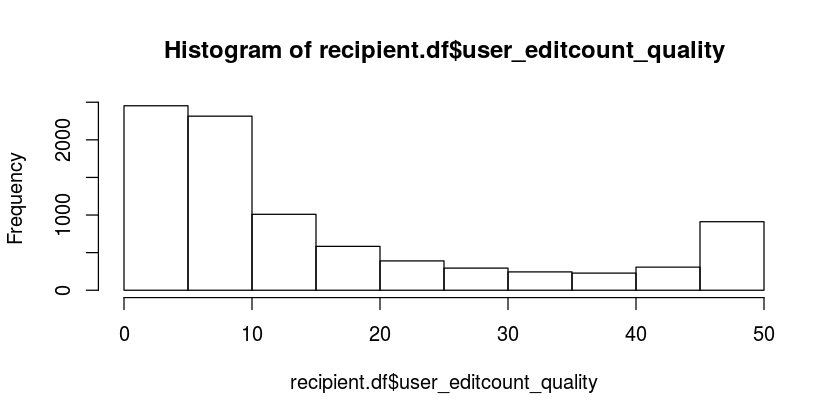

In [29]:
hist(recipient.df$user_editcount_quality)

# Confirm the number of participants

In [30]:
print("Newcomer Participants to Randomize")
summary(subset(recipient.df, newcomer == 1)$lang)

[1] "Newcomer Participants to Randomize"


ar   de   fa   pl 
1135 1929    0  584

In [31]:
## PERSIAN ACCOUNTS 700 fewer than expected
#### if we look over more than a 50 day period 
#### we might be able to increase the Persian experienced account sample

## Polish was cut off at 2400

print("Experienced Participants to Randomize")
summary(subset(recipient.df, newcomer == 0)$lang)

[1] "Experienced Participants to Randomize"


ar   de   fa   pl 
   0    0 2537 2550

# Omit Participants

### Omit Participants in the Thanker Study

In [32]:
print(paste(nrow(recipient.df), "participants before removing thankers"))
recipient.df <- subset(recipient.df, (user_name %in% usernames.to.exclude)!=TRUE)
print(paste(nrow(recipient.df), "participants after removing thankers"))                                      

[1] "8735 participants before removing thankers"
[1] "8625 participants after removing thankers"


### Subset values outside the 99% confidence intervals

In [52]:
## CREATE A PLACEHOLDER WITH ZERO ROWS
## BEFORE ITERATING
recipient.trimmed.df <- recipient.df[0,]

for(l in c("ar", "de", "fa", "pl")){
    print(paste("Language: ", l))
    for(n in c(0,1)){
        print(paste("  newcomer:", n == 1))
        lang.df <- subset(recipient.df, lang==l & newcomer == n)
        print(paste( "     ", nrow(lang.df), "rows from original dataset"))
        df.labor.mean <- mean(lang.df$labor_hours_84_days_pre_sample)
        df.labor.sd   <- sd(lang.df$labor_hours_84_days_pre_sample)
        print(      "      99% confidence intervals:")
        print(paste("          upper: ", df.labor.mean + 2.58 * df.labor.sd ,sep=""))
        print(paste("      Removing", 
            nrow(subset(lang.df,
                        labor_hours_84_days_pre_sample > df.labor.mean + 2.58 * df.labor.sd)), "outliers",
           "observations because labor_hours_84_days_pre_sample is an outlier."))
        lang.subset.df <- subset(lang.df, labor_hours_84_days_pre_sample <= df.labor.mean + 2.58* df.labor.sd)
        print(paste( "     ", nrow(lang.subset.df), "rows in trimmed dataset"))
        recipient.trimmed.df <- rbind(recipient.trimmed.df, lang.subset.df)
    }
}

recipient.df.penultimate <- recipient.trimmed.df

[1] "Language:  ar"
[1] "  newcomer: FALSE"
[1] "      0 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: NaN"
[1] "      Removing 0 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      0 rows in trimmed dataset"
[1] "  newcomer: TRUE"
[1] "      1135 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: 54.7365066602131"
[1] "      Removing 13 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      1122 rows in trimmed dataset"
[1] "Language:  de"
[1] "  newcomer: FALSE"
[1] "      0 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: NaN"
[1] "      Removing 0 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      0 rows in trimmed dataset"
[1] "  newcomer: TRUE"
[1] "      1929 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: 63.3678642498

# Review and Generate Variables

In [34]:
print(aggregate(recipient.df.penultimate[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.penultimate$prev_experience)))

  Group.1 labor_hours_84_days_pre_sample
1       0                          5.847
2      90                         10.531
3     180                         13.630
4     365                         11.945
5     730                         12.980
6    1460                         15.634
7    2920                         21.147


In [35]:
## Update the has_email field
recipient.df.penultimate$has_email <- recipient.df.penultimate$has_email == "True"

## PREVIOUS EXPERIENCE
print("prev_experience")
print(summary(factor(recipient.df.penultimate$prev_experience)))
cat("\n")

## SHOW LABOR HOURS BY EXPERIENCE GROUP:
print("Aggregate labor_hours_84_days_pre_sample")
print(aggregate(recipient.df.penultimate[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.penultimate$prev_experience)))
cat("\n")

print("NEWCOMERS AND EMAILS")
print("--------------------")
print(CrossTable(recipient.df.penultimate$has_email, recipient.df.penultimate$newcomer, 
       prop.r = FALSE, prop.c=TRUE, prop.t = FALSE, prop.chisq = FALSE))

# VARIABLE: num_prev_thanks_pre_treatment
print("num_prev_thanks_pre_sample")
print(summary(recipient.df.penultimate$num_prev_thanks_pre_sample))
cat("\n")
    
## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
print("num_prev_thanks_pre_sample by prev_experience")
print(aggregate(recipient.df.penultimate[c("num_prev_thanks_pre_sample")],
      FUN=mean, by = list(recipient.df.penultimate$prev_experience)))
cat("\n")

[1] "prev_experience"
   0   90  180  365  730 1460 2920 
3609  455  504  759  855 1038 1228 

[1] "Aggregate labor_hours_84_days_pre_sample"
  Group.1 labor_hours_84_days_pre_sample
1       0                          5.847
2      90                         10.531
3     180                         13.630
4     365                         11.945
5     730                         12.980
6    1460                         15.634
7    2920                         21.147

[1] "NEWCOMERS AND EMAILS"
[1] "--------------------"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8448 

 
                                   | recipient.df.penultimate$newcomer 
recipient.df.penultimate$has_email |     FALSE |      TRUE | Row Total | 
-----------------------------------|-----------|-----------|-----------|
                             FALSE |       212 |        33 |       245 | 
        

# Subset Sample to Planned sample sizes
Sample sizes are reported in the experiment [Decisions Document](https://docs.google.com/document/d/1HryhsmWI6WthXQC7zv9Hz1a9DhpZ3FxVRLjTONuMg4I/edit)

* Arabic newcomers (1750 goal) (hoping for as many as possible in first sample)
    * hoping for 1350 in the first sample and 400 later
* German newcomers (3000 goal) (hoping for as many as possible in first sample)
    * hoping for 1600 in first sample and 1400 later
* Persian Experienced (2400 goal)
* Polish:
    * Newcomers: (800 goal)
    * Experienced: (2400 goal)

In [36]:
## Seed generated by Brooklyn Integers
# https://www.brooklynintegers.com/int/1394229439/
set.seed(1394229439)

In [37]:
print("Newcomers")
summary(subset(recipient.df.penultimate, newcomer==1)$lang)

[1] "Newcomers"


ar   de   fa   pl 
1122 1906    0  581

In [38]:
print("Experienced")
summary(subset(recipient.df.penultimate, newcomer==0)$lang)

[1] "Experienced"


ar   de   fa   pl 
   0    0 2419 2420

In [39]:
## WE ARE ACCEPTING THE FULL QUOTA
## OF ALL PARTICIPANTS EXCEPT FOR
## THE DATASET OF Polish EXPERIENCED ACCOUNTS

polish.experienced.sample.size <- 2410
pl.experienced.df <- subset(recipient.df.penultimate, newcomer==0 & lang=="pl")

recipient.df.final <- rbind(
    subset(recipient.df.penultimate, newcomer==1),
    subset(recipient.df.penultimate, lang=="fa"),
    pl.experienced.df[sample(nrow(pl.experienced.df), polish.experienced.sample.size), ]
)


In [40]:
print("Newcomers")
summary(subset(recipient.df.final, newcomer==1)$lang)
print("Experienced")
summary(subset(recipient.df.final, newcomer==0)$lang)

[1] "Newcomers"


ar   de   fa   pl 
1122 1906    0  581

[1] "Experienced"


ar   de   fa   pl 
   0    0 2419 2410

# Generate Randomization Blocks

In [41]:
recipient.df.final$lang_prev_experience <- factor(paste(recipient.df.final$lang, recipient.df.final$prev_experience))
#colnames(recipient.df.final)

In [42]:
## BLOCKING VARIABLES
bv = c("labor_hours_84_days_pre_sample", "num_prev_thanks_pre_sample")

block.size = 2

## TODO: CHECK TO SEE IF I CAN DO BALANCED RANDOMIZATION
## WITHIN BLOCKS LARGER THAN 2
blockobj = block(data=recipient.df.final,
            n.tr = block.size,
            groups = "lang_prev_experience",
            id.vars="anonymized_id",
            block.vars = bv,
            distance ="mahalanobis"
            )
## CHECK DISTANCES
#print(blockobj)
recipient.df.final$randomization_block_id <- createBlockIDs(blockobj,
                                   data=recipient.df.final,
                                   id.var = "anonymized_id")
recipient.df.final$randomization_block_size = block.size

### Identify Incomplete Blocks and Remove Participants in Incomplete Blocks From the Experiment

In [43]:
block.sizes <- aggregate(recipient.df.final$randomization_block_id, FUN=length, by=list(recipient.df.final$randomization_block_id))
incomplete.blocks <- subset(block.sizes, x == 1)$Group.1
incomplete.blocks

[1] 1928 2376 2619 3016 3276 4222

In [44]:
nrow(subset(recipient.df.final, randomization_block_id %in% incomplete.blocks))

[1] 6

In [45]:
removed.observations <- subset(recipient.df.final, (
    randomization_block_id %in% incomplete.blocks)==TRUE)

recipient.df.final <- 
    subset(recipient.df.final, (
        randomization_block_id %in% incomplete.blocks)!=TRUE)

print(paste("Removed", nrow(removed.observations), "units placed in incomplete blocks."))

[1] "Removed 6 units placed in incomplete blocks."


# Generate Randomizations

In [46]:
assignments <- block_ra(blocks=recipient.df.final$randomization_block_id, 
                            num_arms = 2, conditions = c(0,1))
recipient.df.final$randomization_arm <- assignments 

### Check Balance

In [47]:
print("Aggregating labor hours by treatment")
print(aggregate(recipient.df.final[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.final$randomization_arm)))

print("CrossTable of lang by treatment")
CrossTable(recipient.df.final$lang, recipient.df.final$randomization_arm, 
       prop.r = TRUE, prop.c=FALSE, prop.t = FALSE, prop.chisq = FALSE)

print("CrossTable of lang_prev_experience by treatment")
CrossTable(recipient.df.final$lang_prev_experience, recipient.df.final$randomization_arm, 
       prop.r = TRUE, prop.c=FALSE, prop.t = FALSE, prop.chisq = FALSE)


[1] "Aggregating labor hours by treatment"
  Group.1 labor_hours_84_days_pre_sample
1       0                          11.10
2       1                          11.33
[1] "CrossTable of lang by treatment"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  8432 

 
                        | recipient.df.final$randomization_arm 
recipient.df.final$lang |         0 |         1 | Row Total | 
------------------------|-----------|-----------|-----------|
                     ar |       561 |       561 |      1122 | 
                        |     0.500 |     0.500 |     0.133 | 
------------------------|-----------|-----------|-----------|
                     de |       953 |       953 |      1906 | 
                        |     0.500 |     0.500 |     0.226 | 
------------------------|-----------|-----------|-----------|
                     fa |      1208 |      1208 |      24

### Sort by block ID

In [48]:
recipient.df.final <- recipient.df.final[order(recipient.df.final$randomization_block_id),]

In [49]:
print("Newcomers")
summary(subset(recipient.df.final, newcomer==1)$lang)
print("Experienced")
summary(subset(recipient.df.final, newcomer==0)$lang)

[1] "Newcomers"


ar   de   fa   pl 
1122 1906    0  580

[1] "Experienced"


ar   de   fa   pl 
   0    0 2416 2408

# Output and Archive Randomizations

In [28]:
randomization.filename <- paste("thanks-recipient-randomizations-", format(Sys.Date(), format="%Y%m%d"), ".csv", sep="") 
write.csv(recipient.df.final, file = file.path(data.path, "randomization_output", randomization.filename))

# Followup Diagnostics

In [51]:
## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
recipient.df.final$count.var <- 1
print("Number of Accounts for each experience level among Polish Participants")
print(aggregate(subset(recipient.df.final, lang=="pl")[c("count.var")],
      FUN=sum, by = list(subset(recipient.df.final, lang=="pl")$prev_experience)))
cat("\n")

[1] "Number of Accounts for each experience level among Polish Participants"
  Group.1 count.var
1       0       580
2      90       240
3     180       192
4     365       282
5     730       370
6    1460       518
7    2920       806



In [53]:
summary(recipient.df.final$randomization_block_id)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1    1055    2110    2110    3166    4221 